In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
df = pd.read_csv('data.csv', sep=';')

display(df.head())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,16,U,LE3,T,4,3,teacher,services,...,5,4,3,1,2,1,2,16,15,15
1,GP,M,18,U,LE3,T,1,1,other,other,...,2,3,5,2,5,4,0,6,5,0
2,GP,M,17,R,LE3,A,4,4,teacher,other,...,3,3,3,2,3,4,2,10,11,12
3,GP,F,15,U,LE3,T,3,2,services,other,...,4,4,4,1,1,5,10,7,6,6
4,GP,M,16,U,GT3,T,2,3,other,other,...,5,3,3,1,1,3,0,13,14,14


In [9]:
encoded_df = df.copy()
cate_cols = encoded_df.select_dtypes(include='object').columns.tolist()
encoded_df = pd.get_dummies(encoded_df, columns=cate_cols, dtype=int, drop_first=True)

X = encoded_df.drop(['G1', 'G2', 'G3'], axis=1)
y = encoded_df['G3']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




In [45]:
def models_cross_val(X_data, y_data, model_list):

    # split X_train data into x folds with each folds containing a train and valid set
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    scores = []

    # loop to run pipeline for each model
    for model_name, model in model_list.items():

        # run the the model five times with each set of data
        mae = -1 * cross_val_score(model, X_data, y_data,
                                cv=kf,
                                scoring='neg_mean_absolute_error').mean()
        
        mse = -1 * cross_val_score(model, X_data, y_data,
                                cv=kf,
                                scoring='neg_root_mean_squared_error').mean()
        
        r2 = cross_val_score(model, X_data, y_data,
                                cv=kf,
                                scoring='r2').mean()
        
        rmse = 0.5 ** cross_val_score(model, X_data, y_data,
                                cv=kf,
                                scoring='neg_root_mean_squared_error').mean()
        
        scores.append({
            'model': model_name,
            'r2': r2,
            'mae_score': mae,
            'mse_score': mse,
            'rmse': rmse
        })
    
    return scores


models_lst = {'svr': SVR(), 
              'ridge': Ridge(), 
              'k_neighbor': KNeighborsRegressor(), 
              'tree': DecisionTreeRegressor(), 
              'forest': RandomForestRegressor(), 
              'bayesian': BayesianRidge()}

models_cross_val(X_train, y_train, models_lst)

[{'model': 'svr',
  'r2': 0.02593284947281811,
  'mae_score': 3.42871815457993,
  'mse_score': 4.618521372698217,
  'rmse': 24.564813361268026},
 {'model': 'ridge',
  'r2': -0.08814704896241528,
  'mae_score': 3.764142705981334,
  'mse_score': 4.8563861659231335,
  'rmse': 28.967959623172607},
 {'model': 'k_neighbor',
  'r2': 0.10604393494486893,
  'mae_score': 3.4546060606060607,
  'mse_score': 4.4173328639191825,
  'rmse': 21.36730222680395},
 {'model': 'tree',
  'r2': -0.36927859488300124,
  'mae_score': 3.8605050505050507,
  'mse_score': 5.247063660104202,
  'rmse': 36.95452498173102},
 {'model': 'forest',
  'r2': 0.22700063254377018,
  'mae_score': 3.1370606060606057,
  'mse_score': 3.9729906782532978,
  'rmse': 17.416586899029134},
 {'model': 'bayesian',
  'r2': 0.0718770858174668,
  'mae_score': 3.4825884694744618,
  'mse_score': 4.506085947566122,
  'rmse': 22.723071407743824}]

In [63]:
X_train_copy = X_train.copy()

# father edu + mother edu
X_train_copy['FMedu'] = X_train_copy['Fedu'] + X_train_copy['Medu']

# total alc
X_train_copy['total_alc'] = X_train_copy['Walc'] + X_train_copy['Dalc']

X_train_copy['freetime_goout_ratio'] = X_train_copy['freetime'] / X_train_copy['goout']

In [46]:
def feature_selection(X_data, y_data):

    forest_model = RandomForestRegressor()

    rfe = RFE(estimator=forest_model, n_features_to_select=15,)

    rfe.fit(X_data, y_data)

    result = X_data.columns[rfe.support_]

    return result

best_features = feature_selection(X_train, y_train)

print(best_features)

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Walc', 'health', 'absences', 'Mjob_services',
       'schoolsup_yes', 'famsup_yes'],
      dtype='object')


In [67]:
selection_1 = X_train[['age', 'Medu', 'studytime', 'failures', 
                    'famrel', 'freetime', 'goout',
                    'Walc', 'health', 'absences']]

selection_2 = X_train_copy[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Walc', 'health', 'absences', 'Mjob_services',
       'schoolsup_yes', 'famsup_yes', 'freetime_goout_ratio']]

selection_3 = X_train_copy[['age', 'FMedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'total_alc', 'health', 'absences', 'sex_M',
       'Mjob_services', 'Fjob_teacher', 'reason_reputation', 'schoolsup_yes',
       'famsup_yes', 'activities_yes', 'romantic_yes', 'freetime_goout_ratio']]

selection_4 = X_train_copy[['age', 'FMedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'total_alc', 'health', 'absences', 'sex_M',
       'famsize_LE3', 'Mjob_health', 'Mjob_services', 'Fjob_teacher',
       'reason_home', 'reason_reputation', 'guardian_mother', 'schoolsup_yes',
       'famsup_yes', 'activities_yes', 'romantic_yes']]

selection_5 = X_train


selection_list = [{'name': 'selection_1', 'features': selection_1}, 
                  {'name': 'selection_2', 'features': selection_2}, 
                  {'name': 'selection_3', 'features': selection_3},
                  {'name': 'selection_4', 'features': selection_4},
                  {'name': 'selection_5', 'features': selection_5}]

In [68]:
def features_testing(selection, y_data):

    model = RandomForestRegressor()

    # split X_train data into x folds with each folds containing a train and valid set
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    scores = []

    # loop to run pipeline for each model
    for set in selection:
        # run the the model five times with each set of data
        mae = -1 * cross_val_score(model, set['features'], y_data,
                                cv=kf,
                                scoring='neg_mean_absolute_error').mean()
        
        mse = -1 * cross_val_score(model, set['features'], y_data,
                                cv=kf,
                                scoring='neg_root_mean_squared_error').mean()
        
        r2 = cross_val_score(model, set['features'], y_data,
                                cv=kf,
                                scoring='r2').mean()
        
        rmse = 0.5 ** cross_val_score(model, set['features'], y_data,
                                cv=kf,
                                scoring='neg_root_mean_squared_error').mean()
        
        scores.append({
            'model': set['name'],
            'r2': r2,
            'mae_score': mae,
            'mse_score': mse,
            'rmse': rmse
        })
    
    return scores

features_test_result = features_testing(selection_list, y_train)

In [69]:
display(features_test_result)

[{'model': 'selection_1',
  'r2': 0.18423629290462187,
  'mae_score': 3.2161313131313127,
  'mse_score': 4.19156606906921,
  'rmse': 18.06708343332469},
 {'model': 'selection_2',
  'r2': 0.25880762261694457,
  'mae_score': 3.0775252525252528,
  'mse_score': 4.0478009564211,
  'rmse': 16.38867265944713},
 {'model': 'selection_3',
  'r2': 0.2825224183965761,
  'mae_score': 3.0111292929292928,
  'mse_score': 3.9362245117592503,
  'rmse': 15.357181983692609},
 {'model': 'selection_4',
  'r2': 0.275666839099035,
  'mae_score': 2.9218020202020205,
  'mse_score': 3.9715675482829105,
  'rmse': 15.26762684184512},
 {'model': 'selection_5',
  'r2': 0.24459811032644904,
  'mae_score': 3.1120474747474747,
  'mse_score': 4.056390082400862,
  'rmse': 16.576807551449846}]

In [70]:
best_selection = ['age', 'FMedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'total_alc', 'health', 'absences', 'sex_M',
       'Mjob_services', 'Fjob_teacher', 'reason_reputation', 'schoolsup_yes',
       'famsup_yes', 'activities_yes', 'romantic_yes', 'freetime_goout_ratio']

In [121]:
# father edu + mother edu
X_train['FMedu'] = X_train['Fedu'] + X_train['Medu']
X_val['FMedu'] = X_val['Fedu'] + X_val['Medu']
X_test['FMedu'] = X_test['Fedu'] + X_test['Medu']


# total alc
X_train['total_alc'] = X_train['Walc'] + X_train['Dalc']
X_val['total_alc'] = X_val['Walc'] + X_val['Dalc']
X_test['total_alc'] = X_test['Walc'] + X_test['Dalc']


# free time and goout ratio
X_train['freetime_goout_ratio'] = X_train['freetime'] / X_train['goout']
X_val['freetime_goout_ratio'] = X_val['freetime'] / X_val['goout']
X_test['freetime_goout_ratio'] = X_test['freetime'] / X_test['goout']

In [150]:
def params_tuning(X_data, y_data):

    X_data = X_data[best_selection]
   

    tuner = RandomizedSearchCV(RandomForestRegressor(), {
        'n_estimators': range(10,100),
        'criterion': ['squared_error', 'friedman_mse'],
        'max_depth': range(160,180),
        'min_samples_split': range(4,20),
        'min_samples_leaf': range(4,20),
        'max_features': [None]
    }, scoring= 'r2', cv=5, return_train_score=False)

    # tuner = GridSearchCV(RandomForestRegressor(), {
    #     'n_estimators': [10,11,12],
    #     'criterion': ['squared_error'],
    #     'max_depth': [160],
    #     'min_samples_split': [4, 6, 8],
    #     'min_samples_leaf': [4, 6, 8],
    #     'max_features': [None]
    # }, scoring= 'r2', cv=5, return_train_score=False)
    
    tuner.fit(X_data, y_data)

    score_list = []

    result = tuner.cv_results_
    best_params = tuner.best_params_
    best_score = tuner.best_score_

    score_list.append({
        'result': result,
        'best_params': best_params,
        'best_score': best_score
    })
    
    return score_list

tuning_train = params_tuning(X_train, y_train)

In [151]:
params_tuning_df = tuning_train[0]['result']
params_tuning_df = pd.DataFrame(params_tuning_df)
params_tuning_df['param_max_features'].fillna('none', inplace=True)


print(tuning_train[0]['best_params'])
print(tuning_train[0]['best_score'])

{'n_estimators': 27, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 174, 'criterion': 'friedman_mse'}
0.2765741390469875


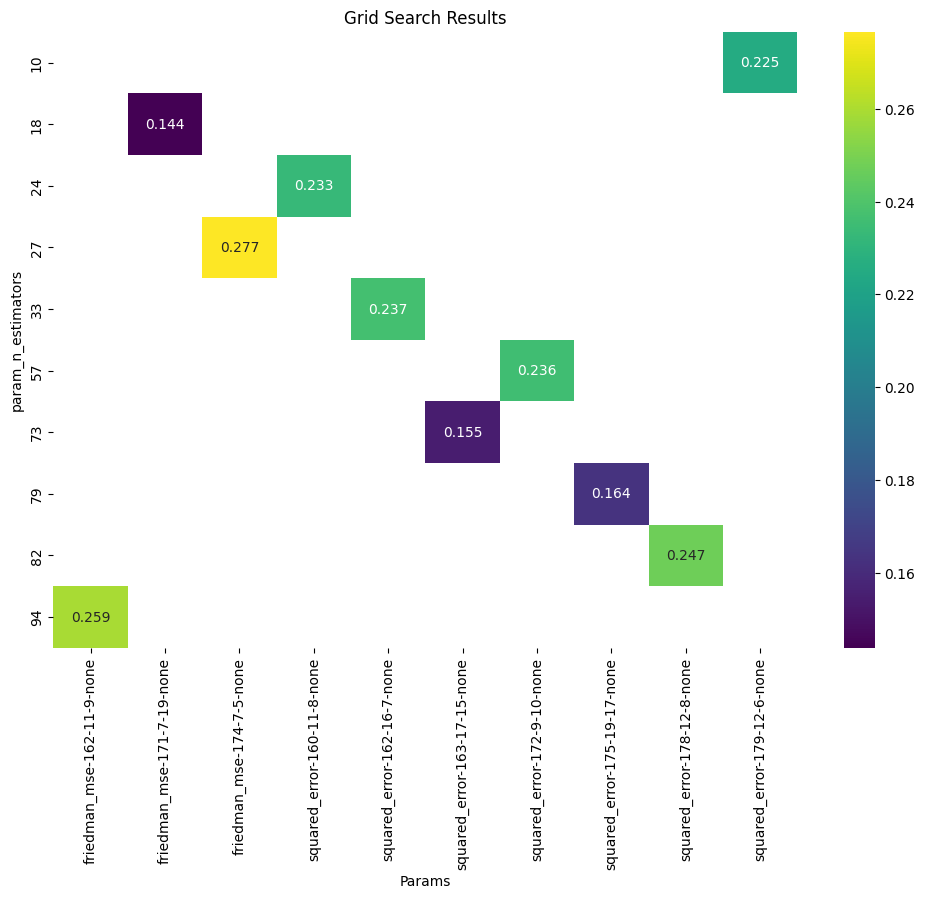

In [152]:
heatmap_data = params_tuning_df.pivot_table(index='param_n_estimators', 
                              columns=['param_criterion',  
                                       'param_max_depth', 
                                       'param_min_samples_split', 
                                       'param_min_samples_leaf', 
                                       'param_max_features'], 
                              values= 'mean_test_score')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.3f', cbar=True)
plt.title('Grid Search Results')
plt.xlabel('Params')
plt.ylabel('param_n_estimators')
plt.show()

In [155]:
X_train = X_train[best_selection]
X_val = X_val[best_selection]
X_test = X_test[best_selection]

In [157]:
final_model = RandomForestRegressor(n_estimators=174, 
                                    criterion='friedman_mse', 
                                    max_depth=160, 
                                    max_features=None,
                                    min_samples_leaf=5, 
                                    min_samples_split=7,
                                    random_state= 5)

final_model.fit(X_train, y_train)

val_pred = final_model.predict(X_val)

r2 = r2_score(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
mse = mean_squared_error(y_val, val_pred)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f'r2 score: {r2}')
print(f'mean absolute error: {mae}')
print(f'mean squared error: {mse}')
print(f'root mse: {rmse}')

r2 score: 0.04273546584891419
mean absolute error: 3.119370307722652
mean squared error: 15.734846190595716
root mse: 3.966717306614591


In [158]:
final_model = RandomForestRegressor(n_estimators=174, 
                                    criterion='friedman_mse', 
                                    max_depth=160, 
                                    max_features=None,
                                    min_samples_leaf=5, 
                                    min_samples_split=7,
                                    random_state= 5)

final_model.fit(X_train, y_train)

test_pred = final_model.predict(X_test)

r2 = r2_score(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f'r2 score: {r2}')
print(f'mean absolute error: {mae}')
print(f'mean squared error: {mse}')
print(f'root mse: {rmse}')

r2 score: 0.1880743391494577
mean absolute error: 2.803626981189223
mean squared error: 14.758087999461745
root mse: 3.8416256974699845
